# Lung and Colon Cancer Detection
This notebook demonstrates the process of building a machine learning model to detect lung and colon cancer using histopathological images. The dataset contains labeled images of cancerous and non-cancerous (<em>healthy</em>) tissues. 

There are five classes in this dataset: 
- Lung benign tissue (<em>healthy</em>)
- Lung adenocarcinoma
- Lung squamos cell carcinoma
- Colon adenocarcinoma
- Colong benign tissue (<em>healthy</em>)

Therefore, this dataset is a multi-class classification.

The goal is to compare different Convolutional Neural Networks (CNNs) to explore the strengths and weaknesses of various architectures and understand which ones perform best for the chosen dataset. Ultimately, the most robust classifier (CNN) will be identified and can accurately identify cancerous lung or colon tissues from the given sample images. 

For a fair comparison of the different CNNs, it is necessary to set some guidelines / rules:
- The dataset has to be properly preprocessed.
- The same training parameters are used 


  - Learning rate
  - Batch size
  - Number of epochs
- The same optimizer is used
  - Isolates the effect of the CNN architecture on performance

Those rules will ensure that the comparison is consistent, controlled and fair.

The dataset used in this notebook is sourced from Kaggle: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/data.

## Required Packages

In [1]:
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

## Dataset Handling
### Import Dataset
The dataset containes 25.000 images.

In [2]:
lung_dataset = '../lung_colon_image_set/lung_image_sets'
colon_dataset = '../lung_colon_image_set/colon_image_sets'

if not os.path.exists(lung_dataset):
    raise FileNotFoundError(f"Dataset path '{lung_dataset}' does not exist!")
if not os.path.exists(colon_dataset):
    raise FileNotFoundError(f"Dataset path '{colon_dataset}' does not exist!")

lung_classes = sorted(os.listdir(lung_dataset))
colon_classes = sorted(os.listdir(colon_dataset))

print(f"Classes found in lung dataset: {lung_classes}")
print(f"Classes found in colon dataset: {colon_classes}")

lc_classes = sorted(set(lung_classes + colon_classes))
print(f"Lung and Colon classes combined: {lc_classes}")

Classes found in lung dataset: ['lung_aca', 'lung_n', 'lung_scc']
Classes found in colon dataset: ['colon_aca', 'colon_n']
Lung and Colon classes combined: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


### Split Dataset
The dataset is split into the following three categories with pre defined percentages:
- Training data (<em>80 %</em>)
- Validation data (<em>10 %</em>)
- Testing data (<em>10 %</em>)

In [3]:
def prepare_splits(data_directories, split_ratios=(0.8, 0.1, 0.1)):
    all_data = {}
    for data_directory in data_directories:
        for class_name in sorted(os.listdir(data_directory)):
            class_directory = os.path.join(data_directory, class_name)
            if os.path.isdir(class_directory):
                all_data.setdefault(class_name, []).extend(os.path.join(class_directory, file_name) for file_name in os.listdir(class_directory))

    for class_name, files in all_data.items():
        print(f"Class '{class_name}' has {len(files)} images")

    dataset_splits = {'training': [], 'validation': [], 'testing': []}

    for class_name, files in all_data.items():
        training_dataset, temporary_dataset = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)

        validation_dataset, testing_dataset = train_test_split(temporary_dataset, test_size=split_ratios[2]/(split_ratios[1] + split_ratios[2]), random_state=42)

        dataset_splits['training'].extend(training_dataset)
        dataset_splits['validation'].extend(validation_dataset)
        dataset_splits['testing'].extend(testing_dataset)

    return dataset_splits

dataset_directories = [lung_dataset, colon_dataset]
dataset_splits = prepare_splits(dataset_directories)

print(f"Training dataset has {len(dataset_splits['training'])} images")
print(f"Validation dataset has {len(dataset_splits['validation'])} images")
print(f"Testing dataset has {len(dataset_splits['testing'])} images")

Class 'lung_aca' has 5000 images
Class 'lung_n' has 5000 images
Class 'lung_scc' has 5000 images
Class 'colon_aca' has 5000 images
Class 'colon_n' has 5000 images
Training dataset has 20000 images
Validation dataset has 2500 images
Testing dataset has 2500 images


### Dataset Class
Initializes the dataset class.

In [4]:
class CancerDetectionDataset(Dataset):
    def __init__(self, file_paths, all_classes, transform=None):
        self.file_paths = file_paths
        self.all_classes = all_classes
        self.labels = [all_classes.index(os.path.basename(os.path.dirname(file_path))) for file_path in file_paths]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

## Mean and Standard Deviation
Overall, normalization and standardization helps in stabilizing and speeding up the training process of machine learning models.

These are the main reasons:
- Subtracting the mean from each image centers the data around zero.
- Dividing by the standard deviation scales the data to have unit variance.
- Normalized inputs can lead to faster and improved convergance during training because the gradients are more stable and the optimization is more efficient.
- Normalization ensures that all input features have are within the same, consistent range.

Calculating the mean and standard deviation of the specific dataset, rather than using standard values, is quite helpful:
- Dataset specificity,
- Improved model performance,
- Avoiding bias and
- Consistency

By calculating the mean and standard deviation specific to the dataset, it is ensured that the normalization is optimal for the data, leading to better model performance and more reliable results.

This step will usually be performed once to determine the mean and standard deviation.

In [5]:
def get_image_paths(dataset_splits):
    keys = ['training', 'validation', 'testing']
    image_paths = []

    for key in keys:
        image_paths.extend(dataset_splits[key])
    
    return image_paths

transformms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ToTensor()
])

def calculate_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

if __name__ == '__main__':
    dataset = CancerDetectionDataset(get_image_paths(dataset_splits), lc_classes, transform=transformms)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    mean, std = calculate_mean_std(loader)
    print(f'Mean: {torch.round(mean, decimals=3)}')
    print(f'Std: {torch.round(std, decimals=3)}')

Mean: tensor([0.6430, 0.5290, 0.7740])
Std: tensor([0.2610, 0.2510, 0.2800])


## Transformer
Transforms the images.

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.643, 0.529, 0.774], std=[0.262, 0.252, 0.280])
])

## Dataset Classes und Data Loaders
Builds the dataset classes and data loadersfor the training, validation and test data.

In [7]:
training_dataset = CancerDetectionDataset(dataset_splits['training'], lc_classes, transform=transform)
validation_dataset = CancerDetectionDataset(dataset_splits['validation'], lc_classes, transform=transform)
testing_dataset = CancerDetectionDataset(dataset_splits['testing'], lc_classes, transform=transform)

training_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
testing_loader = DataLoader(testing_dataset, batch_size=16, shuffle=False)

## GPU Initialization
Activates the GPU in order to utilize it.

In [8]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"Using device: {device}")

MPS available: True
Using device: mps


## CNN-Models
The starting point for this experiment is the deep convolutional neural network model 'VGG-16'. This model is composed of 16 layers (13 convolutional layers & 3 fully connected layers). VVG16 is known for it's "simplicity" and depth. Furthermore, the model is often used as a benchmark. But, 'VVG-16' is not the most performant nor accurate and especially not trained quickly.

The 'init' constructur initializes the layers of the VGG-16 model. Convolutional layers are with batch normalization and ReLU activation functions. Max pooling is applied after layers 2, 4, 7 and 10 to reduce spatial dimensions. The fully connected layers use dropout to prevent overfitting and ReLU activation functions.

The 'forward' method defines the forward pass of the model. <br>
out = self.layer1(x) <br> 
-> passes the input x through the first convolutional layer (layer1).out = self.layer2out) <br> 
-> passes the output of the first layer trough the second convolutional layer (layer2) ... <br>
out = out.reshape(out.size(0), -1) -> flattens the output from convolutional layers to a 1D tensor and passes the flattened output through the fully connected layers.

In [9]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Model Training
Training of the model with the training dataset and validating the model with the validation dataset. This happens over a pre defined number of epochs. <br>
This function saves the training losses, validation losses and validation accuracy for each epoch.

### Process
- Initializes the Adam Optimizer and the Cross-Entropy Loss Function
  

  - The loss function is defined to measure the difference between the predicted and actual labels
  - An optimizer is chosen to update the model's weights based on the gradients computed during backpropagation
- Moves the model to the CPU
- Initializes lists to save the training losses, validation losses and validation accuracy
- Training steps per epoch:


  - Move data (image & labels) to device
  - Reset gradient
  - Update parameter
  - Accumulate loss
  - Calculate and print out average training losses 
- Validation steps per epoch:


  -  Set evaluation mode for model
  -  Reset validation loss
  -  Initialize counters for predictions
  -  For each batch:
  

     -  Move data (image & labels) to device
     -  Calculate loss
     -  Accumulate loss
     -  Analyze predictions
     -  Calculate accuracy
  -  Calculate and print out average validation loss and validation accuracy
-  Returns the lists for the training losses, validation losses and validation accuracies

The statistics will be saved to .csv file.


In [16]:
def train_model(model, training_loader, validation_loader, stats_df, number_epochs = 5, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    training_losses = []
    validation_losses = []
    validation_accuracies = []
    epoch_number = []
    epoch_runtimes = []
    total_duration = 0

    for epoch in range(number_epochs):
        epoch_start_time = time.time()
        epoch_number.append(epoch + 1)

        model.train()
        running_loss = 0.0

        for images, labels in training_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_training_loss = running_loss / len(training_loader)
        training_losses.append(epoch_training_loss)

        print(f"Epoch {epoch + 1}/{number_epochs}, Training Loss: {running_loss/len(training_loader)}")

        
        model.eval()
        validation_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        epoch_validation_loss = validation_loss / len(validation_loader)
        validation_accuracy = 100 * correct_predictions / total_predictions
        validation_losses.append(epoch_validation_loss)
        validation_accuracies.append(validation_accuracy)

        validation_accuracy = 100 * correct_predictions / total_predictions

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_runtimes.append(f"{epoch_duration:.2f}")
        minutes = int(epoch_duration // 60)
        seconds = int(epoch_duration % 60)
        total_duration += epoch_duration

        print(f"Validation Loss: {validation_loss/len(validation_loader)}, Validation Accuracy: {validation_accuracy} %")
        print(f"Epoch {epoch + 1} completed in {minutes} minutes and {seconds} seconds")

    stats_df = stats_df.append({
        'Epoch': epoch_number,
        'Training Loss': training_losses,
        'Validation Loss': validation_losses,
        'Validation Accuracy': validation_accuracies,
        'Epoch Duration (s)': epoch_runtimes
    }, ingore_index=True)

    stats_df.to_csv('../mlp-private/VVG-16/training_stats.csv', index=False)

    total_minutes = int(total_duration // 60)
    total_seconds = int(total_duration % 60)
    print(f"Total time: {total_minutes} minutes and {total_seconds} seconds")

    stats_df.loc[len(stats_df)] = ['Total time (s)', '', '', '', f"{total_duration:.2f}"]
    stats_df.to_csv('../mlp-private/VVG-16/training_stats.csv', index=False)

    return training_losses, validation_losses, validation_accuracies, stats_df

## Main Part
Trains the model and saves the training losses, validation losses and validation accuracy for each epoch.

In [ ]:
if __name__ == "__main__":
    stats_df = pd.DataFrame()

    model = VGG16(num_classes=len(lc_classes)).to(device)
    training_losses, validation_losses, validation_accuracies, stats_df = train_model(model, training_loader, validation_loader, stats_df)

    print("Training completed!")

Epoch 1/5, Training Loss: 1.0207394997596742
Validation Loss: 0.5775079964890958, Validation Accuracy: 64.4 %
Epoch 1 completed in 6 minutes and 27 seconds
Epoch 2/5, Training Loss: 0.6694173014163971
Validation Loss: 0.48555551839325845, Validation Accuracy: 73.04 %
Epoch 2 completed in 6 minutes and 44 seconds
Epoch 3/5, Training Loss: 0.541894959282875
Validation Loss: 0.3965417583395911, Validation Accuracy: 85.84 %
Epoch 3 completed in 6 minutes and 48 seconds
Epoch 4/5, Training Loss: 0.38639820853471757
Validation Loss: 0.2973848071751957, Validation Accuracy: 87.12 %
Epoch 4 completed in 6 minutes and 47 seconds
Epoch 5/5, Training Loss: 0.32768960306048395
Validation Loss: 0.19995803126878212, Validation Accuracy: 92.72 %
Epoch 5 completed in 6 minutes and 43 seconds
Total time: 33 minutes and 31 seconds
Training completed!


## Predictions Visualization
Visualizes the predictions of the trained model.

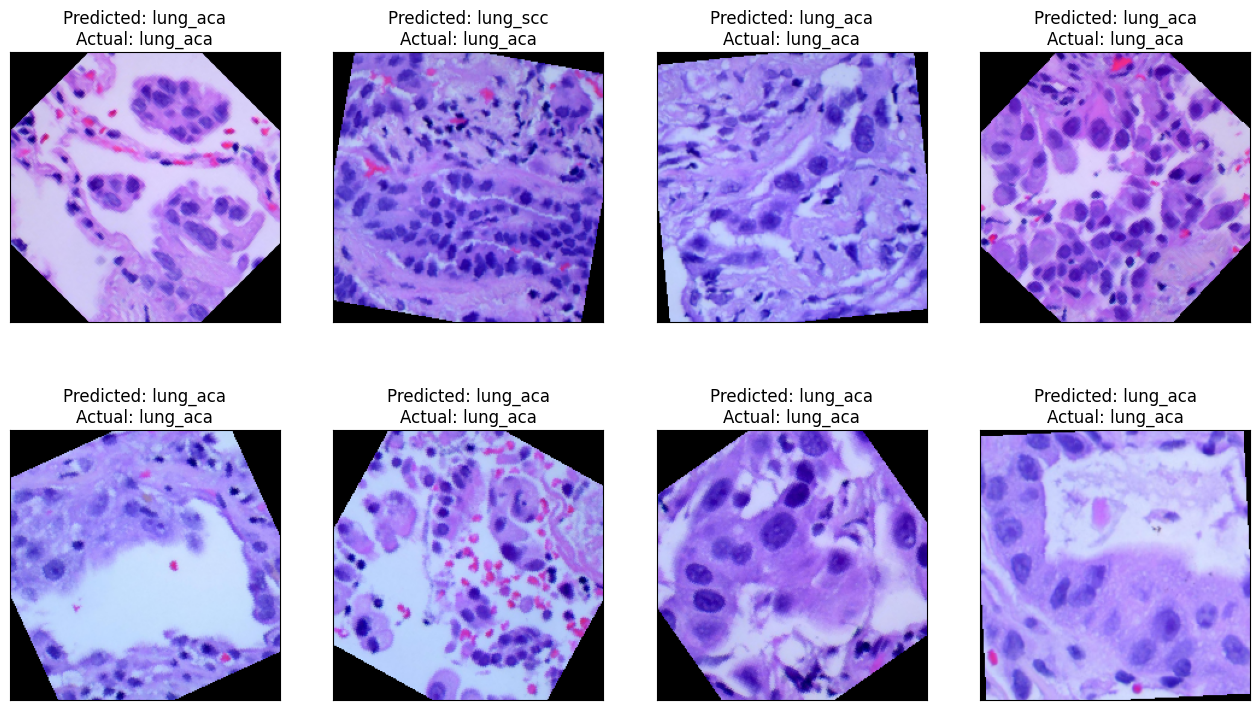

In [12]:
def visualize_predictions(model, testing_loader, lc_classes):
    model.eval()
    images, labels = next(iter(testing_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    figure = plt.figure(figsize=(16, 9))
    for idx in range(8):
        ax = figure.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
        image = images[idx].permute(1, 2, 0)
        image = image * torch.tensor([0.262, 0.252, 0.280]) + torch.tensor([0.643, 0.529, 0.774])
        image = image.numpy().clip(0, 1)
        ax.imshow(image)
        ax.set_title(f'Predicted: {lc_classes[predicted[idx]]}\nActual: {lc_classes[labels[idx]]}')
    
    plt.savefig('../mlp-private/VVG-16/predictions.png')
    plt.show()

visualize_predictions(model, testing_loader, lc_classes)

## Model Testing
Tests the trained and validated model in order to get the test accuracy.

In [17]:
def test_model(model, testing_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in testing_loader:
            test_start_time = time.time()

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        
    test_accuracy = 100 * test_correct / test_total

    test_end_time = time.time()
    test_duration = test_end_time - test_start_time

    print(f"Test Accuracy: {test_accuracy:.2f} %")
    print(f"Testing completed in {test_duration} seconds")

    stats_df.loc[len(stats_df)] = ['Test Accuracy', '', '', test_accuracy, '']
    stats_df.to_csv('../mlp-private/VVG-16/training_stats.csv', index=False)
    
    return all_labels, all_predictions

all_labels, all_predictions = test_model(model, testing_loader)

Test Accuracy: 91.96 %
Testing completed in 0.012460947036743164 seconds


ValueError: cannot set a frame with no defined columns

## Confusion Matrix
The confusion matrix is important for several reasons:
- **Detailed Performance Analysis:** Provides a detailed breakdown of the model's performance by showing the number of true positives, true negatives, fales positives and fales negatives. This helps in understanding how well the model is performing for each class.
- **Class-wise Performance:** Allows to see how well the model is performing for each individual class. This is particularly useful in multi-class classification problems where the performance might vary significantly across different classes.
- **Identifying Misclassification:** Identify which classes are being misclassified and understand the nature of these errors. This might help in diagnosing issues with the model and the data
- **Precision, Recall and F1-Score:** Is used as a base to calculate important metrics for each class. The metrics provide a more comprehensive evaluation of the model's performance beyond overall accuracy.
- **Model Improvement:** Gain vital insights that can guide further improvements to the model, such as data augmentation, class rebalancing or adjusting the model architecture.

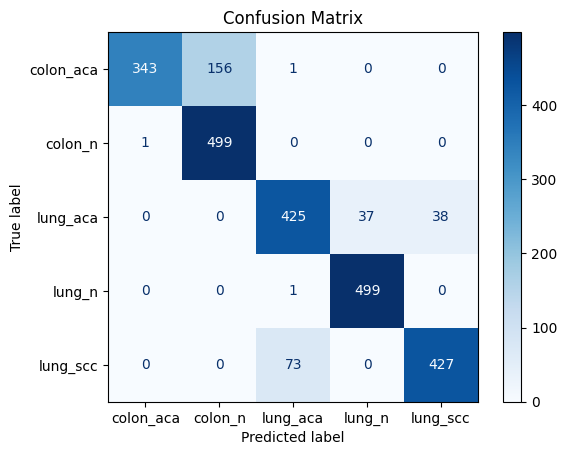

In [38]:
cm = confusion_matrix(all_labels, all_predictions, labels=range(len(lc_classes)))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lc_classes)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig('../mlp-private/VVG-16/confusion_matrix.png')
plt.show()

## Visualization Training Loss, Validation Loss & Validation Accuracy
Visualizes the training, loss, validation loss and validation accuracy with appropriate graphs.

In [ ]:
def plot_loss_accuracy(training_losses, validation_losses, validation_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.savefig('../mlp-private/VVG-16/loss_accuracy.png')
    plt.show()

plot_loss_accuracy(training_losses, validation_losses, validation_accuracies)

## Additional Metrics
Additional metrics are helpful in order to be able to evaluate the performance of the CNN model even further. The following metrics are in particular helpful:
- **Precision Score**
  - The ratio of true positive predictions to the total number of positive predictions (true positives + false positives). It indicates how many of the predicted positives are actually positive.
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$
- **Recall Score**
  - The ratio of true positive predictions to the total number of acutal positives (true positives + false negatives). It indicates how many of the acutal positives were correctly identified.
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$
- **F1-Score**
  - The F1-score is a measure of a model's accuracy that considers both precision and recall. This score is the harmonic mean (Mittelwert) of precision and recall and ranges from 0 to 1, where 1 indivates perfect precision and recall and 0 indicates the worst performance.
$$
\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
- **Precision-Recall Curve**
  - Is a graphical representation used to evaluate the performance of a binary classifier ("yes or no" decision based on the input data), especially when dealing with imbalanced datasets. It plots precision (positive predictive value) against recall (sensitivity) at verious threshold settings. The curve helps visualize the trade-off between precision and recall for different thresholds. <em>But, the precision-recall curve does not support multi-class setting out of the box. So, for each each class in the multi-class dataset a precision-recall curve will be created.</em> Interpretation of the Curve:
    - High Precision, Low Recall: Indicates that the classifier is very accurate when it predicts a positiv, but it misses many positive instances.
    - Low Precision, High Recall: Indicates that the classifier captures most of the positives instances but also includes many false positives.

In [3]:
precision = precision_score(all_labels, all_predictions, average='weighted')
print(f"Precision Score: {precision}")

stats_df.loc[len(stats_df)] = ['Precision Score', '', '', precision, '']
stats_df.to_csv('../mlp-private/VVG-16/training_stats.csv', index=False)

recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Recall Score: {recall}")

stats_df.loc[len(stats_df)] = ['Recal Score', '', '', recall, '']
stats_df.to_csv('../mlp-private/VVG-16/training_stats.csv', index=False)

f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"F1-Score: {f1}")

stats_df.loc[len(stats_df)] = ['F1-Score', '', '', f1, '']
stats_df.to_csv('../mlp-private/VVG-16/training_stats.csv', index=False)

"""
precision_values, recall_values, _ = precision_recall_curve(all_labels, all_predictions, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=precision_values, recall=recall_values)
pr_display.plot()
plt.title("Precision-Recall Curve")
plt.savefig('../mlp-private/VVG-16/precision_recall_curve.png')
plt.show()
"""

for i in range(all_predictions.shape[1]):
    precision_values, recall_values, _ = precision_recall_curve(all_labels == i, all_predictions[:, i])
    pr_display = PrecisionRecallDisplay(precision=precision_values, recall=recall_values)
    pr_display.plot()
    plt.title(f"Precision-Recall Curve for class {i}")
    plt.savefig(f"../mlp-private/VVG-16/precision_recall_curve_class-{i}.png")
    plt.show()

NameError: name 'all_labels' is not defined